# Titanic 연습
 - baseline 만들기
 - 앙상블 Cross validation 개념 잡기

## 1. 데이터 준비

### 1.1 패키지 로딩

In [1]:
import pandas as pd
import numpy as np
import re 
from collections import Counter


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns',13)
pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings(action='ignore')

<ipython-input-1-c3f38f7031fa>:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### 1.2 데이터 로딩

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('gender_submission.csv')

In [3]:
tmp_train = train.copy()
tmp_test = test.copy()
tmp_sub = submission.copy()

In [4]:
print(tmp_train.shape)
print(round(tmp_train.isnull().sum()/len(train),3))  # 결측치 확인

(891, 12)
PassengerId    0.000
Survived       0.000
Pclass         0.000
Name           0.000
Sex            0.000
Age            0.199
SibSp          0.000
Parch          0.000
Ticket         0.000
Fare           0.000
Cabin          0.771
Embarked       0.002
dtype: float64


In [5]:
tmp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Data columns (total 12 columns):
    Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64    ** drop  O </br>
 1   Survived     891 non-null    int64    ** target
 2   Pclass       891 non-null    int64    ** cate
 3   Name         891 non-null    object   ** drop(==Sex)
 4   Sex          891 non-null    object   ** LabelEncoding
 5   Age          714 non-null    float64  ** Name참조 호칭별 나이 적용
 6   SibSp        891 non-null    int64    ** Sibling + Spouse
 7   Parch        891 non-null    int64    ** Parent + Child
 8   Ticket       891 non-null    object   ** cate
 9   Fare         891 non-null    float64  ** Pclass 상관관계
 10  Cabin        204 non-null    object   ** drop
 11  Embarked     889 non-null    object   ** cate

## 2.데이터 전처리

In [6]:
del tmp_train['PassengerId']
del tmp_test['PassengerId']

### 2.1 Target 변수 추출 (labels)

In [7]:
labels = tmp_train.Survived #target

### 2.2 범주화
 - ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [8]:
obj = []
for i in train.columns:
    if train[i].dtype == 'object':
        obj.append(i)
print(obj)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [10]:
tmp_train['Pclass'] = tmp_train['Pclass'].astype('category')
print(tmp_train['Pclass'])

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: category
Categories (3, int64): [1, 2, 3]


#### 2.2.1 Name, Age 변수 활용
 - Name 호칭별 연령 평균 도출
 - Age Null 변수에 평균 대치

In [9]:
##1. 인덱스 추출
tmp_train_index = tmp_train.loc[tmp_train['Age'].isnull(),'Name'].index

##2. 호칭추출
called = tmp_train['Name']

pat1 = re.compile('([a-zA-Z]+)\.')
called2=called.apply(pat1.findall)
tmp_train['called'] = [i[0] for i in called2]

##3. 호칭별 나이 평균
tmp_train['called'].value_counts()
round(tmp_train.groupby(['called'])['Age'].mean(),2)


called
Capt        70.00
Col         58.00
Countess    33.00
Don         40.00
Dr          42.00
Jonkheer    38.00
Lady        48.00
Major       48.50
Master      4.57 
Miss        21.77
Mlle        24.00
Mme         24.00
Mr          32.37
Mrs         35.90
Ms          28.00
Rev         43.17
Sir         49.00
Name: Age, dtype: float64

In [12]:
tmp_train.loc[tmp_train_index,'called'].value_counts()

Nan_Age=tmp_train.loc[tmp_train_index,'called']

Age_tunning=[]
for i in Nan_Age:
    if i == 'Mr':
        Age_tunning.append(32)
    elif i =='Miss':
        Age_tunning.append(22)
    elif i == 'Mrs':
        Age_tunning.append(36)
    elif i == 'Master':
        Age_tunning.append(5)
    else:
        Age_tunning.append(42)

aging=pd.Series(Age_tunning,tmp_train_index)

tmp_train.loc[tmp_train_index,'Age'] = aging


##### 2.2.1.1 Age band
 - 20 단위로 생성

In [10]:
tmp_train['Age']
bins = [0, 20, 40, 60, 100]
tmp_train['Age_band']=pd.cut(tmp_train['Age'], bins=bins, labels = ['1','2','3','4'])

tmp_train.drop(['Age','Name'],axis=1, inplace = True)

#### 2.2.2 Sex 범주화

In [11]:
tmp_train['Sex']=pd.Series(np.where(tmp_train['Sex'] == 'male',0,1)).astype('category')

#### 2.2.3 Cabin, Ticket, Embarked

In [12]:
del tmp_train['Cabin']

In [13]:
tmp_train['Ticket'].head(50)
# p2 = re.compile('([\d)+')

0     A/5 21171       
1     PC 17599        
2     STON/O2. 3101282
3     113803          
4     373450          
5     330877          
6     17463           
7     349909          
8     347742          
9     237736          
10    PP 9549         
11    113783          
12    A/5. 2151       
13    347082          
14    350406          
15    248706          
16    382652          
17    244373          
18    345763          
19    2649            
20    239865          
21    248698          
22    330923          
23    113788          
24    349909          
25    347077          
26    2631            
27    19950           
28    330959          
29    349216          
30    PC 17601        
31    PC 17569        
32    335677          
33    C.A. 24579      
34    PC 17604        
35    113789          
36    2677            
37    A./5. 2152      
38    345764          
39    2651            
40    7546            
41    11668           
42    349253          
43    SC/Pa

In [30]:
[i[0] if len(i) == 0 else i[-1] for i in train['Ticket'].str.split()]

['21171',
 '17599',
 '3101282',
 '113803',
 '373450',
 '330877',
 '17463',
 '349909',
 '347742',
 '237736',
 '9549',
 '113783',
 '2151',
 '347082',
 '350406',
 '248706',
 '382652',
 '244373',
 '345763',
 '2649',
 '239865',
 '248698',
 '330923',
 '113788',
 '349909',
 '347077',
 '2631',
 '19950',
 '330959',
 '349216',
 '17601',
 '17569',
 '335677',
 '24579',
 '17604',
 '113789',
 '2677',
 '2152',
 '345764',
 '2651',
 '7546',
 '11668',
 '349253',
 '2123',
 '330958',
 '23567',
 '370371',
 '14311',
 '2662',
 '349237',
 '3101295',
 '39886',
 '17572',
 '2926',
 '113509',
 '19947',
 '31026',
 '2697',
 '34651',
 '2144',
 '2669',
 '113572',
 '36973',
 '347088',
 '17605',
 '2661',
 '29395',
 '3464',
 '3101281',
 '315151',
 '33111',
 '2144',
 '14879',
 '2680',
 '1601',
 '348123',
 '349208',
 '374746',
 '248738',
 '364516',
 '345767',
 '345779',
 '330932',
 '113059',
 '14885',
 '3101278',
 '6608',
 '392086',
 '19950',
 '343275',
 '343276',
 '347466',
 '5734',
 '2315',
 '364500',
 '374910',
 '17754

In [14]:
tmp_train.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked', 'called', 'Age_band'],
      dtype='object')

In [15]:
tmp_train['Age_band'] = tmp_train['Age_band'].astype('category')

In [16]:
labels

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

TypeError: unsupported operand type(s) for *: 'AxesSubplot' and 'int'

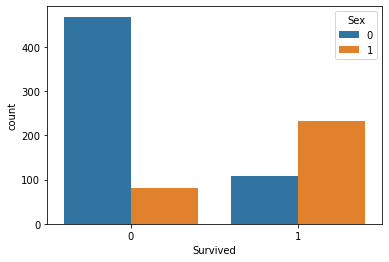

In [18]:
sns.countplot(tmp_train['Survived'],hue = tmp_train['Sex'])*100
plt.show()

In [19]:
print('percentage of male survived:', tmp_train.groupby('Sex')['Survived'].value_counts(normalize=True)*100)

percentage of male survived: Sex  Survived
0    0           81.109185
     1           18.890815
1    1           74.203822
     0           25.796178
Name: Survived, dtype: float64


percentage of pclasss survived: Pclass  Survived
1       1           62.962963
        0           37.037037
2       0           52.717391
        1           47.282609
3       0           75.763747
        1           24.236253
Name: Survived, dtype: float64


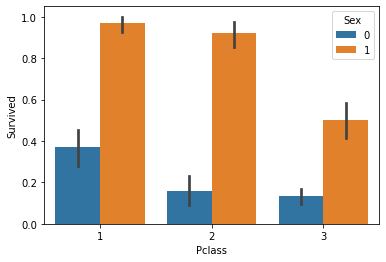

In [20]:
sns.barplot(x = tmp_train['Pclass'], y=tmp_train['Survived'], hue=tmp_train['Sex'])
print('percentage of pclasss survived:', train.groupby(['Pclass'])['Survived'].value_counts(normalize = True)*100)

Pclass vs Sex

Pclass  Sex  Survived
1       0    0           63.114754
             1           36.885246
        1    1           96.808511
             0           3.191489 
2       0    0           84.259259
             1           15.740741
        1    1           92.105263
             0           7.894737 
3       0    0           86.455331
             1           13.544669
        1    0           50.000000
             1           50.000000
Name: Survived, dtype: float64

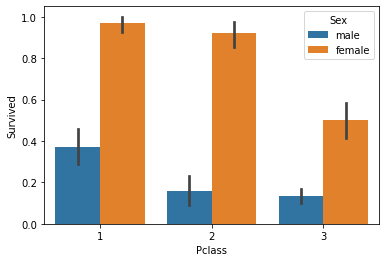

In [21]:
sns.barplot(x=tmp_train['Pclass'], y=labels, hue = train['Sex'])
tmp_train.groupby(['Pclass','Sex'])['Survived'].value_counts(normalize=True)*100

<AxesSubplot:>

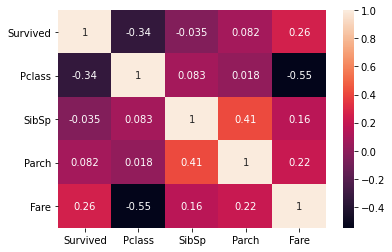

In [22]:
# 컬럼별 상관관계
# 카이스퀘어 제곱을 통해 범주형과 타겟의 관계 도출
sns.heatmap(tmp_train.corr(), annot = True)


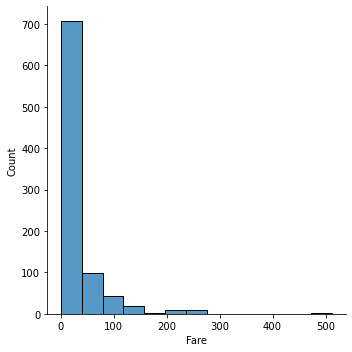

In [23]:
# 요금 분포
sns.displot(tmp_train['Fare'], bins=13) #gussian distribution

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

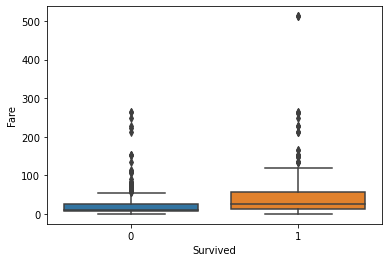

In [26]:
sns.boxplot(y=train['Fare'], x= train['Survived'])

In [27]:
# Null values
print(train.isnull().sum(), '\n\n\n', test.isnull().sum())

PassengerId    0  
Survived       0  
Pclass         0  
Name           0  
Sex            0  
Age            177
SibSp          0  
Parch          0  
Ticket         0  
Fare           0  
Cabin          687
Embarked       2  
dtype: int64 


 PassengerId    0  
Pclass         0  
Name           0  
Sex            0  
Age            86 
SibSp          0  
Parch          0  
Ticket         0  
Fare           1  
Cabin          327
Embarked       0  
dtype: int64


In [28]:
tmp_train.columns
tmp_train.drop(['Survived'],axis=1, inplace=True)

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(tmp_train, labels, test_size=0.2, random_state = 1234)

In [30]:
models = {'KNN':KNeighborsClassifier(),
         'SVC' : SVC(probability=True),
         'DecisionTreeClassifier': DecisionTreeClassifier()}